In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sb
import numpy as np

In [2]:
# load the full dataset and display it
(train_X, train_y), (test_X, test_y) = mnist.load_data()
targetimage = train_X[1]

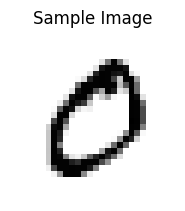

In [3]:
fig, ax = plt.subplots(figsize=(2,2),layout="constrained")

ax.imshow(targetimage.reshape((28,28)), interpolation='none', cmap=cm.Greys)
ax.axis('off')
plt.suptitle(f"Sample Image")
plt.show()

In [4]:
def feature_scale(data_unscaled, scaled=True):
    if scaled == False:
        return data_unscaled

    max_value = np.max(data_unscaled)

    data_scaled = np.array(data_unscaled)
    data_scaled = data_scaled / max_value
    # min max normalization
    
    return data_scaled

targetimage = feature_scale(targetimage, scaled=True)

In [5]:
targetimage = targetimage.flatten().astype(np.float64)
pixels = len(targetimage)
xcoordinates = np.linspace(0, 1, pixels).astype(np.float64).reshape((-1, 1))

In [6]:
degree = 10
poly = PolynomialFeatures(degree)
xcoordinates_poly = poly.fit_transform(xcoordinates)

In [7]:
reg = LinearRegression().fit(xcoordinates_poly, targetimage)
predicted_image = reg.predict(xcoordinates_poly)
reg.score(xcoordinates_poly, targetimage)

0.11292689888064888

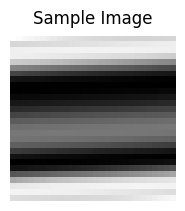

In [8]:
fig, ax = plt.subplots(figsize=(2,2),layout="constrained")

ax.imshow(predicted_image.reshape((28,28)), interpolation='none', cmap=cm.Greys)
ax.axis('off')
plt.suptitle(f"Sample Image")
plt.show()

In [9]:
clf = linear_model.Lasso(alpha=0.0000000000000001,max_iter=100)
reg = clf.fit(xcoordinates_poly, targetimage)
predicted_image = reg.predict(xcoordinates_poly)
reg.score(xcoordinates_poly, targetimage)
print(reg.coef_)

[ 0.          0.97871821 -0.84604624 -0.10870891  0.04306867  0.01209735
 -0.03498236 -0.05414234 -0.04433462 -0.01518389  0.0236403 ]


C:\Users\abhin\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.934e+01, tolerance: 8.485e-03
  model = cd_fast.enet_coordinate_descent(


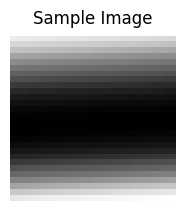

In [10]:
fig, ax = plt.subplots(figsize=(2,2),layout="constrained")

ax.imshow(predicted_image.reshape((28,28)), interpolation='none', cmap=cm.Greys)
ax.axis('off')
plt.suptitle(f"Sample Image")
plt.show()

In [11]:
xcoordinates_wave = np.array(xcoordinates)
samples = 200
# assuming the period is 1
for i in range(samples):
    wavefeatures_sin = np.sin(2 * np.pi * (i+1) * xcoordinates)
    wavefeatures_cos = np.cos(2 * np.pi * (i+1) * xcoordinates)

    xcoordinates_wave = np.hstack([xcoordinates_wave, wavefeatures_sin, wavefeatures_cos])
print(xcoordinates_wave.shape)

(784, 401)


In [12]:
reg = LinearRegression().fit(xcoordinates_wave, targetimage)
predicted_image = reg.predict(xcoordinates_wave)
print(reg.coef_.shape)

(401,)


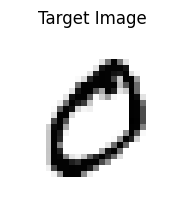

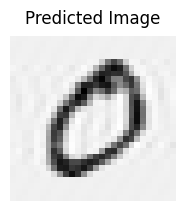

In [13]:
fig, ax = plt.subplots(figsize=(2,2),layout="constrained")

ax.imshow(targetimage.reshape((28,28)), interpolation='none', cmap=cm.Greys)
ax.axis('off')
plt.suptitle(f"Target Image")
plt.show()

fig, ax = plt.subplots(figsize=(2,2),layout="constrained")

ax.imshow(predicted_image.reshape((28,28)), interpolation='none', cmap=cm.Greys)
ax.axis('off')
plt.suptitle(f"Predicted Image")
plt.show()

In [14]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
targetimage = train_images[1]
targetimage = np.mean(targetimage, axis=2, keepdims=True)

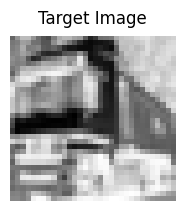

In [15]:
fig, ax = plt.subplots(figsize=(2,2),layout="constrained")

ax.imshow(targetimage.reshape((32, 32)), interpolation='none', cmap=cm.Greys)
ax.axis('off')
plt.suptitle(f"Target Image")
plt.show()

In [16]:
targetimage = feature_scale(targetimage, scaled=True)
targetimage = targetimage.flatten().astype(np.float64)

pixels = len(targetimage)
xcoordinates = np.linspace(0, 1, pixels).astype(np.float64).reshape((-1, 1))

In [17]:
xcoordinates_wave = np.array(xcoordinates)
samples = 350
# assuming the period is 1
for i in range(samples):
    wavefeatures_sin = np.sin(2 * np.pi * (i+1) * xcoordinates)
    wavefeatures_cos = np.cos(2 * np.pi * (i+1) * xcoordinates)

    xcoordinates_wave = np.hstack([xcoordinates_wave, wavefeatures_sin, wavefeatures_cos])
print(xcoordinates_wave.shape)

(1024, 701)


In [18]:
reg = LinearRegression().fit(xcoordinates_wave, targetimage)
predicted_image = reg.predict(xcoordinates_wave)
print(reg.coef_.shape)

(701,)


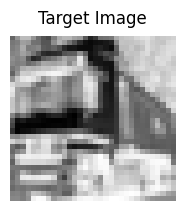

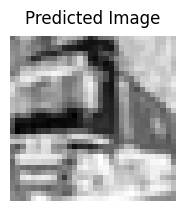

In [19]:
fig, ax = plt.subplots(figsize=(2,2),layout="constrained")

ax.imshow(targetimage.reshape((32,32)), interpolation='none', cmap=cm.Greys)
ax.axis('off')
plt.suptitle(f"Target Image")
plt.show()

fig, ax = plt.subplots(figsize=(2,2),layout="constrained")

ax.imshow(predicted_image.reshape((32,32)), interpolation='none', cmap=cm.Greys)
ax.axis('off')
plt.suptitle(f"Predicted Image")
plt.show()

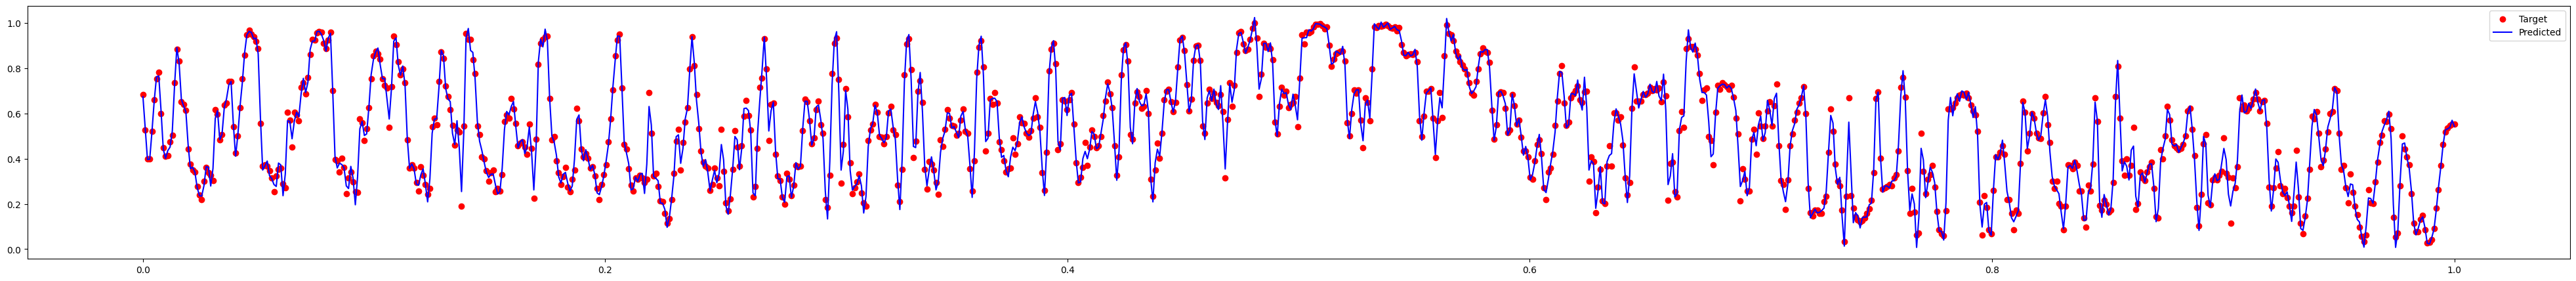

In [20]:
fig,ax = plt.subplots(figsize=(50,5))
ax.scatter(xcoordinates.flatten(), targetimage, color="r",label="Target")
ax.plot(xcoordinates.flatten(), predicted_image, color="b",label="Predicted")
ax.legend()